In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from utils import *

# Data Loading & Preprocessing

In [2]:
event = "벤츠 화재"
communities = ['clien', 'bobae', 'fmkorea', 'naver_cafe']

In [3]:
per_community_dfs = []
for community in communities:
    posts_df = pd.read_csv(f'../data/{event}/{community}_posts.csv') 
    posts_df['from'] = community
    posts_df.created_at = posts_df.created_at.apply(parse_dates)

    comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
    if community=='clien': #TODO: clien dataset cmt_author, post_id가 바뀌어 있음.
        comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
    comments_df = comments_df.groupby(['post_id'], as_index = False).agg({
        'cmt_author': ['count'],
    })

    comments_df.columns = comments_df.columns.droplevel(0)
    comments_df.columns = ['post_id', 'cmt_count']
    per_community_df = pd.merge(posts_df, comments_df, left_on='id', right_on='post_id', how='left')
    per_community_dfs.append(per_community_df)
df = pd.concat(per_community_dfs)

In [4]:
print(df.shape)
df.isnull().sum()

(1093, 12)


id               0
title            0
content         53
likes            0
url              0
author           0
views            0
created_at       0
updated_at    1023
from             0
post_id         55
cmt_count       55
dtype: int64

In [5]:
# Preprocessing
df = df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
df.views = df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
df.likes = df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
df.cmt_count = df.cmt_count.fillna(0).map(int)
print(df.shape)

# filtering by keyword & add created_day column
keywords = list(event.split())
filtered_df = filter_by_keyword(df, keywords)
filtered_df = add_created_day_col(filtered_df).sort_values(by=['created_at'])

(1093, 12)


# 화제성 시각화

In [6]:
# Per day Post (count)
vis_df = filtered_df
day_start = filtered_df.created_day.min()
day_end = filtered_df.created_day.max()
day_start = '2024-07-01'
day_end = '2024-08-17'

title = "Per day Number of Posts (count)"
result_df = plot_per_day_post_counts_with_events(vis_df, title=title, day_start=day_start, day_end=day_end)

In [7]:
# Per day number of views (total)
vis_df = filtered_df
day_start = '2024-07-01'
day_end = '2024-08-17'
title = "Per day Number of Views (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='views', day_start=day_start, day_end=day_end)

In [8]:
# Per day number of comments (total)
vis_df = filtered_df
day_start = '2024-07-01'
day_end = '2024-08-17'
title = "Per day Number of Comments (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='cmt_count', day_start=day_start, day_end=day_end)

In [9]:
# Per day number of likes (total)
vis_df = filtered_df
day_start = '2024-07-01'
day_end = '2024-08-17'
title = "Per day Number of Likes (Total)"
result_df = plot_per_day_target_val_sum_with_events(vis_df, title=title, target_val='likes', day_start=day_start, day_end=day_end)

# Hot 게시물 선정 및 댓글 수 변화 추이 확인

In [10]:
hot_posts = filtered_df[filtered_df['created_day'] =='2024-08-02']
hot_posts = hot_posts.sort_values(by=['cmt_count', 'views', 'likes'], ascending=[False, False, False])
hot_posts.head(3)

,id,title,content,likes,url,author,views,created_at,updated_at,from,post_id,cmt_count,created_day
27,18776452,청라 전기차 화재 주차장 수습현장,해당 주차당은 그냥 초토화 되었고 이외에 인접한 주차장 쪽도 그을음이 심하고 환기구...,26.0,https://www.clien.net/service/board/cm_car/187...,엑스베이스,21990,2024-08-02 13:30:45,2024-08-02 13:34:21,clien,18776452.0,78,2024-08-02
21,18776665,전기차 주차 당분간은 시끄럽겠네용,NaN,0.0,https://www.clien.net/service/board/cm_car/187...,힝힝이,9128,2024-08-02 18:49:39,NaN,clien,18776665.0,65,2024-08-02
332,1525144,청라 전기차화재 관리사무소 보상안내,NaN,1.0,https://cafe.naver.com/ca-fe/ArticleRead.nhn?c...,마음IEVI창원,5387,2024-08-02 12:46:00,NaN,naver_cafe,1525144.0,54,2024-08-02


In [11]:
# load dataset with full comments info
per_community_dfs = []
for community in communities:
    posts_df = pd.read_csv(f'../data/{event}/{community}_posts.csv') 
    posts_df['from'] = community
    posts_df.created_at = posts_df.created_at.apply(parse_dates)

    comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
    comments_df.cmt_created_at = comments_df.cmt_created_at.apply(parse_dates)
    if community=='clien':
        comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
    per_community_df = pd.merge(posts_df, comments_df, left_on='id', right_on='post_id', how='left')
    per_community_dfs.append(per_community_df)
df = pd.concat(per_community_dfs)

In [19]:
condition = (df.id==18776452) | (df.id==18776665) | (df.id==1525144)
hot_post_df = df[condition]
hot_post_df['rel_time'] = hot_post_df['cmt_created_at'] - hot_post_df['created_at'] # time delta
hot_post_df['rel_time'] = hot_post_df['rel_time'].apply(timedelta_to_seconds) // (30*60) # applying binnig (30 minutes)

/var/folders/w5/5pw5wgsx5vj49hnx6bdft1_80000gn/T/ipykernel_69096/3071351110.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w5/5pw5wgsx5vj49hnx6bdft1_80000gn/T/ipykernel_69096/3071351110.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Cumulative Sum of Post (post id: 18776452)')

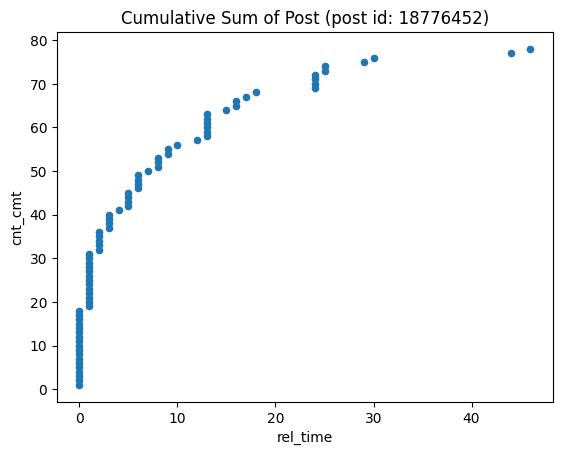

In [20]:
post_id = 18776452
post_df = hot_post_df[hot_post_df.id==post_id].sort_values(by=['rel_time'])
post_df['cnt_cmt'] = [x for x in range(1, post_df.shape[0]+1)]
post_df.plot(x='rel_time', y='cnt_cmt', kind='scatter')
plt.title(f"Cumulative Sum of Post (post id: {post_id})")

Text(0.5, 1.0, 'Cumulative Sum of Post (post id: 18776665)')

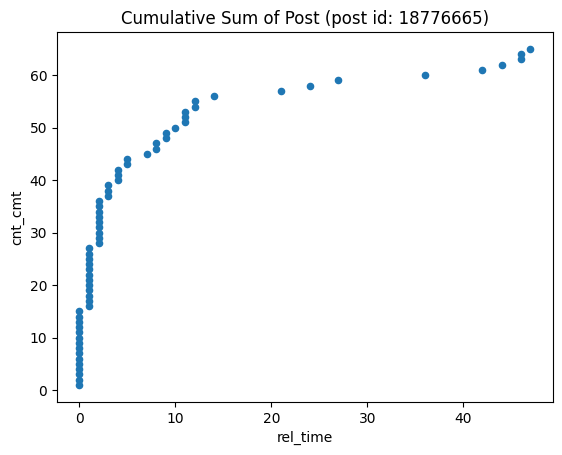

In [23]:
post_id = 18776665
post_df = hot_post_df[hot_post_df.id==post_id].sort_values(by=['rel_time'])
post_df['cnt_cmt'] = [x for x in range(1, post_df.shape[0]+1)]
post_df.plot(x='rel_time', y='cnt_cmt', kind='scatter')
plt.title(f"Cumulative Sum of Post (post id: {post_id})")

Text(0.5, 1.0, 'Cumulative Sum of Post (post id: 1525144)')

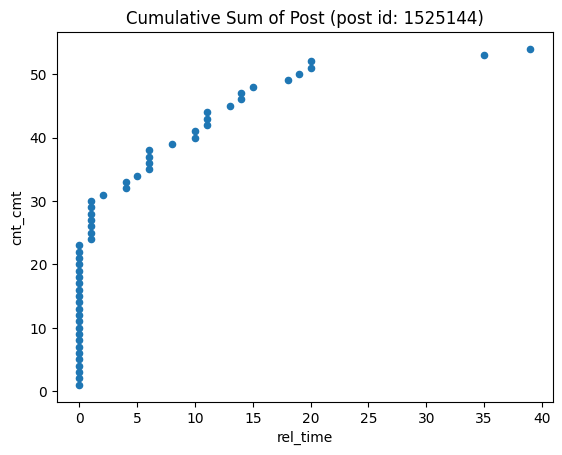

In [24]:
post_id = 1525144
post_df = hot_post_df[hot_post_df.id==post_id].sort_values(by=['rel_time'])
post_df['cnt_cmt'] = [x for x in range(1, post_df.shape[0]+1)]
post_df.plot(x='rel_time', y='cnt_cmt', kind='scatter')
plt.title(f"Cumulative Sum of Post (post id: {post_id})")